In [1]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
# All credits to https://github.com/joaofig/pyloess
def tricubic(x):
    y = np.zeros_like(x)
    idx = (x >= -1) & (x <= 1)
    y[idx] = np.power(1.0 - np.power(np.abs(x[idx]), 3), 3)
    return y


class Loess(object):

    @staticmethod
    def normalize_array(array):
        min_val = np.min(array)
        max_val = np.max(array)
        return (array - min_val) / (max_val - min_val), min_val, max_val

    def __init__(self, xx, yy, degree=1):
        self.n_xx, self.min_xx, self.max_xx = self.normalize_array(xx)
        self.n_yy, self.min_yy, self.max_yy = self.normalize_array(yy)
        self.degree = degree

    @staticmethod
    def get_min_range(distances, window):
        min_idx = np.argmin(distances)
        n = len(distances)
        if min_idx == 0:
            return np.arange(0, window)
        if min_idx == n-1:
            return np.arange(n - window, n)

        min_range = [min_idx]
        while len(min_range) < window:
            i0 = min_range[0]
            i1 = min_range[-1]
            if i0 == 0:
                min_range.append(i1 + 1)
            elif i1 == n-1:
                min_range.insert(0, i0 - 1)
            elif distances[i0-1] < distances[i1+1]:
                min_range.insert(0, i0 - 1)
            else:
                min_range.append(i1 + 1)
        return np.array(min_range)

    @staticmethod
    def get_weights(distances, min_range):
        max_distance = np.max(distances[min_range])
        weights = tricubic(distances[min_range] / max_distance)
        return weights

    def normalize_x(self, value):
        return (value - self.min_xx) / (self.max_xx - self.min_xx)

    def denormalize_y(self, value):
        return value * (self.max_yy - self.min_yy) + self.min_yy

    def estimate(self, x, window, use_matrix=False, degree=1):
        n_x = self.normalize_x(x)
        distances = np.abs(self.n_xx - n_x)
        min_range = self.get_min_range(distances, window)
        weights = self.get_weights(distances, min_range)

        if use_matrix or degree > 1:
            wm = np.multiply(np.eye(window), weights)
            xm = np.ones((window, degree + 1))

            xp = np.array([[math.pow(n_x, p)] for p in range(degree + 1)])
            for i in range(1, degree + 1):
                xm[:, i] = np.power(self.n_xx[min_range], i)

            ym = self.n_yy[min_range]
            xmt_wm = np.transpose(xm) @ wm
            beta = np.linalg.pinv(xmt_wm @ xm) @ xmt_wm @ ym
            y = (beta @ xp)[0]
        else:
            xx = self.n_xx[min_range]
            yy = self.n_yy[min_range]
            sum_weight = np.sum(weights)
            sum_weight_x = np.dot(xx, weights)
            sum_weight_y = np.dot(yy, weights)
            sum_weight_x2 = np.dot(np.multiply(xx, xx), weights)
            sum_weight_xy = np.dot(np.multiply(xx, yy), weights)

            mean_x = sum_weight_x / sum_weight
            mean_y = sum_weight_y / sum_weight

            b = (sum_weight_xy - mean_x * mean_y * sum_weight) / \
                (sum_weight_x2 - mean_x * mean_x * sum_weight)
            a = mean_y - b * mean_x
            y = a + b * n_x
        return self.denormalize_y(y)


In [33]:
# estimated from
xx = np.array([i for i in range(1,25)])
yy = np.array([26, 25.5, 25, 24.7, 24.5, 24.5, 24.8, 25, 26.5, 27, 
               30, 32, 33.5, 34, 34.8, 35, 34.8, 34, 32, 28, 
               27.4, 26.6, 26.3, 26])

y2 = np.array([26, 25.5, 25, 24.7, 24.5, 24.5, 24.8, 25, 26.5, 28, 
               32, 34, 34.9, 36, 37, 44.3, 44.7, 40.7, 33.5, 29, 
               27.4, 26.6, 26.3, 26])

loess = Loess(xx, yy)
loess2 = Loess(xx, y2)

fy = []
fy2 = []

for x in xx:
    y = loess.estimate(x, window=7, use_matrix=False, degree=1)
    fy.append(y)
    
    yyz = loess2.estimate(x, window = 8, use_matrix = False, degree = 1)
    fy2.append(yyz)

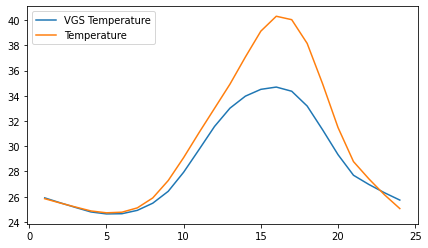

In [42]:
%matplotlib inline
plt.figure(figsize=(7, 4))
plt.plot(xx, fy, label='VGS Temperature')
plt.plot(xx, fy2, label='Temperature')
plt.legend(loc="upper left")